In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import scipy.stats as stats
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [19]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200]
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
data['boolQuality'] = 0
data['boolQuality'][data['quality']>5] = 1

In [20]:
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:,None]

In [21]:
train_data,test_data,train_labels,test_labels = train_test_split(dataT,labels,test_size=.1)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data = torch.utils.data.TensorDataset(test_data,test_labels)
batchsize = 32
train_loader = DataLoader(train_data,batch_size=batchsize, shuffle = True, drop_last= True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [22]:
class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()
    self.input = nn.Linear(11,16)
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)
    self.output = nn.Linear(32,1)
    self.actfun = actfun
  def forward(self,x):
    actfun = getattr(torch,self.actfun)
    x = actfun(self.input(x))
    x = actfun(self.fc1(x))
    x = actfun(self.fc2(x))
    return self.output(x)

In [25]:
numepochs = 1000
def TraintheModel():
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr = .01)
  losses = torch.zeros(numepochs)
  trainAcc =[]
  testAcc = []
  for epochi in range (numepochs):
    winenet.train()
    batchAcc = []
    batchLoss = []
    for X,y in train_loader:
      yHat = winenet(X)
      loss = lossfun(yHat,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batchLoss.append(loss.item())
      batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
    trainAcc.append(np.mean(batchAcc))
    losses[epochi] = np.mean(batchLoss)
    winenet.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = winenet(X)
    testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
  return trainAcc,testAcc,losses



In [26]:
activation_funs = ['relu','tanh','sigmoid']
trainbyAcc = np.zeros((numepochs,len(activation_funs)))
testbyAcc = np.zeros((numepochs,len(activation_funs)))
for ai,actfun in enumerate(activation_funs):
  winenet = ANNwine(actfun)
  trainbyAcc[:,ai],testbyAcc[:,ai],losses = TraintheModel()

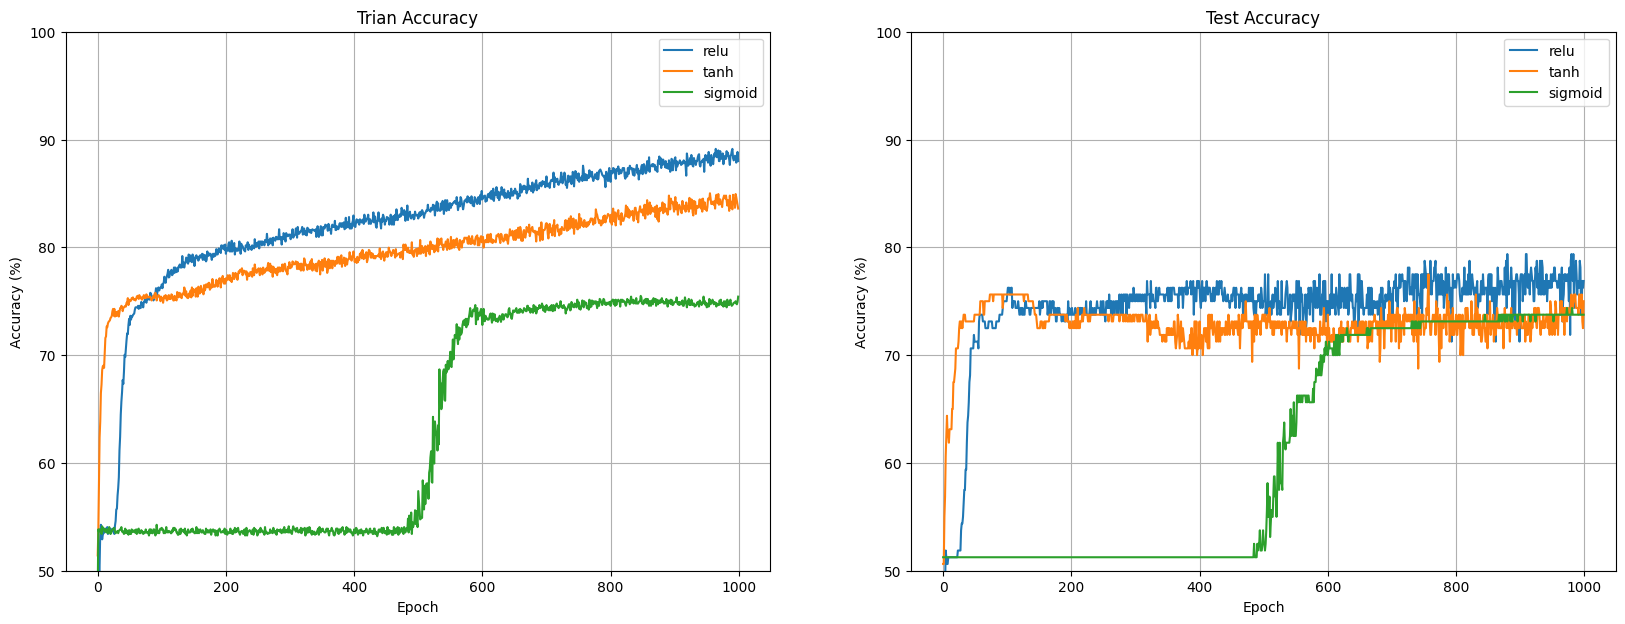

In [28]:
fig,ax = plt.subplots(1,2,figsize=(20,7))
ax[0].plot(trainbyAcc)
ax[0].set_title('Trian Accuracy')
ax[1].plot(testbyAcc)
ax[1].set_title('Test Accuracy')

for i in range(2):
  ax[i].legend(activation_funs)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()